In [ ]:
# Version V1.1:
# Separate file for segmentation re-do. Multiple files can be re-segmented at the same time using modelNames. 
# Script loops through all datapaths and modelNames. 
# Version V2:
# Switched nuclear segmentation to be stored as a binary mask, and stored foreground and nuc in fmsk, with fmask_channels. This will require different featurization function calls in featurize and track steps

#Version RM2.1 
#added second nuclear mask from iRFP channel

In [3]:
import os; os.getcwd()

'/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM'

## h5 File Resegmentation

#### Load Libraries

In [4]:
#%%capture
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('/home/wsltools/programs/celltraj/celltraj')
import trajectory
import imageprep as imprep
import utilities
import features
import model
import h5py
import pickle
import os
import subprocess
import time
#import bootstrap
import umap
import pyemma.coordinates as coor
import scipy
import csaps
import skimage
from IPython.display import clear_output
import os
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
np.float=np.dtype(float)
np.int=int
import msmtools
import pandas
import itertools

Solver suite is scipy


/home/copperma/anaconda3/envs/cellpose_celltraj_env/lib/python3.8/site-packages/pyntcloud/utils/numba.py:5: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def groupby_count(xyz, indices, out):
/home/copperma/anaconda3/envs/cellpose_celltraj_env/lib/python3.8/site-packages/pyntcloud/utils/numba.py:12: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def groupby_sum(x

#### Load File Details

In [5]:
#%%capture

# This date is to make folders of analysis based off the date you do the analysis. 
date = '5dec24'
os.system(f'mkdir -p {date}')

# Make sure the model names are correct since these are what the file names have been called. If you want to rename
# the files, use script 'file_rename'
modelNames = [f'20241004_OS17lungInh2_RM'] 

datapaths=['/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM']

In [6]:
# some convenience visualization functions here, eventually these will be incorporated into the packages....

# Defines the function show_image_3channel which takes in three images and an optional axis parameter.
def show_image_3channel(bf_img,nuc_img,rep_img,ax=None):
        if ax is None:
            ax=plt.gca()
        ax.imshow(imprep.znorm(bf_img),cmap=plt.cm.binary,clim=(-5,5))
        cs=ax.contour(imprep.znorm(nuc_img),cmap=plt.cm.BuPu,levels=np.linspace(0,np.percentile(imprep.znorm(nuc_img),99),7),alpha=.5,linewidths=.5)
        cs.cmap.set_over('purple')
        cs=ax.contour(imprep.znorm(rep_img),cmap=plt.cm.YlOrBr_r,levels=np.linspace(0,np.percentile(imprep.znorm(rep_img),99),7),alpha=.25,linewidths=.5)
        cs.cmap.set_over('yellow')
        return ax

def rescale_to_int(img,maxint=2**16-1,dtype=np.uint16):
    img=maxint*((img-np.min(img))/np.max(img-np.min(img)))
    return img.astype(dtype)

def show_3dseg_zproj(fig,im3d,labels,fmap=None,fmapscale=None,labels2=None,fmsk=None,zscale=None):
    if zscale is not None:
        im3d=skimage.transform.rescale(im3d,(zscale,1,1),anti_aliasing=False)
        labels=skimage.transform.rescale(labels,(zscale,1,1),order=0)
        if labels2 is not None:
            labels2=skimage.transform.rescale(labels2,(zscale,1,1),order=0)
        if fmap is not None:
            fmap=skimage.transform.rescale(fmap,(zscale,1,1),anti_aliasing=False)
    zproj=np.sum(im3d,axis=0)
    xproj=np.sum(im3d,axis=1)
    yproj=np.sum(im3d,axis=2)
    labels_zproj=np.max(labels,axis=0)
    labels_xproj=np.max(labels,axis=1)
    labels_yproj=np.max(labels,axis=2)
    plt.subplot(1,3,1)
    plt.imshow(zproj,cmap=plt.cm.gray_r)
    plt.contour(labels_zproj,levels=np.arange(np.max(labels_zproj)),colors='blue',linewidths=1)
    if fmap is not None:
        #plt.contour(np.max(fmap,axis=0),levels=np.linspace(np.min(fmap),np.max(fmap),21),cmap=plt.cm.PiYG_r)
        plt.imshow(np.max(fmap,axis=0),cmap=plt.cm.YlOrRd,alpha=.33,clim=fmapscale)
    if labels2 is not None:
        labels2_zproj=np.max(labels2,axis=0)
        plt.contour(labels2_zproj,levels=np.arange(np.max(labels2_zproj)),colors='green',linewidths=1)
    if fmsk is not None:
        fmsk_zproj=np.max(fmsk,axis=0)
        plt.contour(fmsk_zproj,levels=np.arange(np.max(fmsk_zproj)),colors='red',linewidths=1)    
    plt.axis('equal');plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(xproj,cmap=plt.cm.gray_r)
    plt.contour(labels_xproj,levels=np.arange(np.max(labels_xproj)),colors='blue',linewidths=1)
    if fmap is not None:
        #plt.contour(np.max(fmap,axis=0),levels=np.linspace(np.min(fmap),np.max(fmap),21),cmap=plt.cm.PiYG_r)
        plt.imshow(np.max(fmap,axis=1),cmap=plt.cm.YlOrRd,alpha=.33,clim=fmapscale)
    if labels2 is not None:
        labels2_xproj=np.max(labels2,axis=1)
        plt.contour(labels2_xproj,levels=np.arange(np.max(labels2_xproj)),colors='green',linewidths=1)
    if fmsk is not None:
        fmsk_xproj=np.max(fmsk,axis=1)
        plt.contour(fmsk_xproj,levels=np.arange(np.max(fmsk_xproj)),colors='red',linewidths=1)    
    plt.axis('equal');plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(yproj,cmap=plt.cm.gray_r)
    plt.contour(labels_yproj,levels=np.arange(np.max(labels_yproj)),colors='blue',linewidths=1)
    if fmap is not None:
        #plt.contour(np.max(fmap,axis=0),levels=np.linspace(np.min(fmap),np.max(fmap),21),cmap=plt.cm.PiYG_r)
        plt.imshow(np.max(fmap,axis=2),cmap=plt.cm.YlOrRd,alpha=.33,clim=fmapscale)
    if labels2 is not None:
        labels2_yproj=np.max(labels2,axis=2)
        plt.contour(labels2_yproj,levels=np.arange(np.max(labels2_yproj)),colors='green',linewidths=1)
    if fmsk is not None:
        fmsk_yproj=np.max(fmsk,axis=2)
        plt.contour(fmsk_yproj,levels=np.arange(np.max(fmsk_yproj)),colors='red',linewidths=1)    
    plt.axis('equal');plt.axis('off')

def log_ztransform(img):
    img=np.log(imprep.znorm(img)+1.-np.min(imprep.znorm(img)))
    return img

def nuc_viewtransform(im3d_nuc,zcut_nuc=2.0,rsmooth=1.0,zscale=5.0):
    im3d_nuc=skimage.filters.gaussian(im3d_nuc,sigma=[rsmooth/zscale,rsmooth,rsmooth])
    im3d_nuc=imprep.znorm(im3d_nuc)
    im3d_nuc[im3d_nuc<zcut_nuc]=0
    im3d_nuc=rescale_to_int(log_ztransform(im3d_nuc))
    return im3d_nuc

def bf_viewtransform(im3d_bf,rsmooth=10.0,zscale=5.0,zcut=2.0,remove_background=False):
    im3d_bf=skimage.filters.difference_of_gaussians(im3d_bf,.5,1.5)
    if remove_background:
        im3d_bf_smth=skimage.filters.gaussian(np.abs(im3d_bf),sigma=[rsmooth/zscale,rsmooth,rsmooth])
        msk_bf=imprep.znorm(im3d_bf_smth)>zcut
        msk_bf=binary_fill_holes_2dstack(msk_bf)
    im3d_bf=rescale_to_int(log_ztransform(im3d_bf))
    im3d_bf=np.max(im3d_bf)-im3d_bf
    if remove_background:
        im3d_bf[np.logical_not(msk_bf)]=0
    return im3d_bf

def rep_viewtransform(im3d_rep,rsmooth=1.0,zscale=5.0):
    im3d_rep=skimage.filters.gaussian(im3d_rep,sigma=[rsmooth/zscale,rsmooth,rsmooth])
    im3d_rep=rescale_to_int(log_ztransform(im3d_rep))
    return im3d_rep

def binary_fill_holes_2dstack(im3d):
    for iz in range(im3d.shape[0]):
        im3d[iz,...]=ndimage.binary_fill_holes(im3d[iz,...])
    return im3d

#### Loop through the segmented files

In [7]:
#%%capture
import imageprep as imprep
import itertools

modelLists = [None]*len(modelNames)
inds_imagingSet=[]
for idataset in range(len(modelNames)):
    modelLists[idataset]=imprep.list_images(f'{datapaths[idataset]}/{modelNames[idataset]}_xy*_roi*.h5')
    inds_dataset=[idataset]*len(modelLists[idataset])
    inds_imagingSet.append(inds_dataset)

inds_imagingSet=list(itertools.chain(*inds_imagingSet))

In [8]:
#%%capture

for ilist in range(len(modelLists)):
    print(f'movies: {modelLists[ilist]}')

movies: ['/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy0_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy10_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy11_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy12_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy13_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy14_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy15_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy16_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_

#### Segmentation Re-do

In [25]:
from cellpose import models

ndimage=scipy.ndimage
nucl=25                                 #typical nucleus linear diameter pixels
micron_per_pixel=.33                    #lateral resolution (image pixel size)
micron_per_z=3.0                        #axial resolution between z-slices
zscale=micron_per_z/micron_per_pixel

vizpath='/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241209_3dsm_segredo'
pathexists = os.path.isdir(vizpath)     #create image folder if it doesn't exist already
if not pathexists:
    os.mkdir(vizpath)
    
# Information for nuclear segmentation re-do
cellpose_modelpath_nuc='/mnt/z/ImagingData/segmentation/cellpose_models/rawan/20240930_Collective_E5000_Scratch_G_B'
model_nuc = models.CellposeModel(gpu=True,pretrained_model=cellpose_modelpath_nuc)
cellpose_channels_nuc = [[2,3]]
cellprob_threshold_nuc=0.
minsize=int(np.pi*(nucl/2.)**2)         #at least one nuclear slices
maxsize=int(((8*nucl)**3)/zscale);
cellpose_diam_nuc=26.39                  #from mean mask size in training
flow_threshold_nuc=0.8
visual=True; 
live_render=True                        #setting parameters and paths for segmentation

# Information for cytoplasmic segmentation re-do
cellpose_modelpath='/mnt/z/ImagingData/segmentation/cellpose_models/rawan/Col_OS14_Scratch_G_B_E500_20241127'
model = models.CellposeModel(gpu=True,pretrained_model=cellpose_modelpath)
cellpose_channels = [[2,3]]
cellprob_threshold=0.
flow_threshold=0.4
minsize=int(np.pi*(nucl/2.)**2)        #at least one nuclear slices
maxsize=int(((8*nucl)**3)/zscale)
cellpose_diam=43.5                  #from mean mask size in training
visual=True



mask_channels=['cyto']
fmask_channels=['foreground','nuc']
#fmskchannel=2
mskchannel=0
nmaskchannels=len(mask_channels)
rsmooth=nucl/4
rsmooth_nuc=nucl/10
visual=True
zcut=1.0
zcut_nuc=2.

combine_nuc_channels=True #for instance if you want to combine DAPI and H2B reporter channels together for training data
nuc_channel2=1

** TORCH CUDA version installed and working. **
>>>> using GPU (CUDA)
>>>> loading model /mnt/z/ImagingData/segmentation/cellpose_models/rawan/20240930_Collective_E5000_Scratch_G_B
>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
>>>> model diam_labels =  26.391 (mean diameter of training ROIs)
** TORCH CUDA version installed and working. **
>>>> using GPU (CUDA)
>>>> loading model /mnt/z/ImagingData/segmentation/cellpose_models/rawan/Col_OS14_Scratch_G_B_E500_20241127
>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
>>>> model diam_labels =  42.690 (mean diameter of training ROIs)


loading /home/wsltools/projects/Rawan/20240810_PCLS_OS17_R6M1_inhset2_N1/20241004_OS17lungInh2_RM_xy7_roi1.h5
interpreting image as zxyc
interpreting mask as zxyc
loading /home/wsltools/projects/Rawan/20240810_PCLS_OS17_R6M1_inhset2_N1/20241004_OS17lungInh2_RM_xy7_roi1.h5:/cell_data_m0/
error loading metadata from /home/wsltools/projects/Rawan/20240810_PCLS_OS17_R6M1_inhset2_N1/20241004_OS17lungInh2_RM_xy7_roi1.h5: "Unable to open object (object 'cell_data_m0' doesn't exist)"
interpreting image as zxyc
interpreting mask as zxyc
saving attributes ['cellpose_modelpath_nuc', 'cellpose_modelpath'] to /metadata in /home/wsltools/projects/Rawan/20240810_PCLS_OS17_R6M1_inhset2_N1/20241004_OS17lungInh2_RM_xy7_roi1.h5
overwrote existing and saved cellpose_modelpath_nuc to /home/wsltools/projects/Rawan/20240810_PCLS_OS17_R6M1_inhset2_N1/20241004_OS17lungInh2_RM_xy7_roi1.h5//metadata
overwrote existing and saved cellpose_modelpath to /home/wsltools/projects/Rawan/20240810_PCLS_OS17_R6M1_inhset2_N

KeyboardInterrupt: 

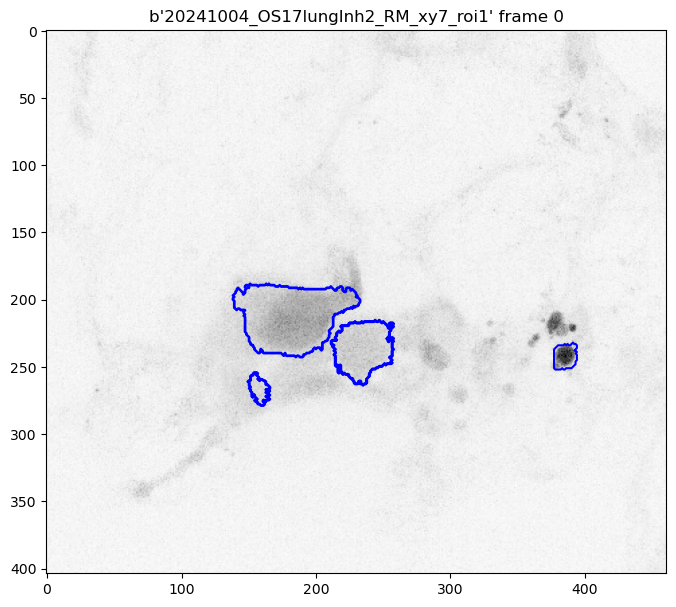

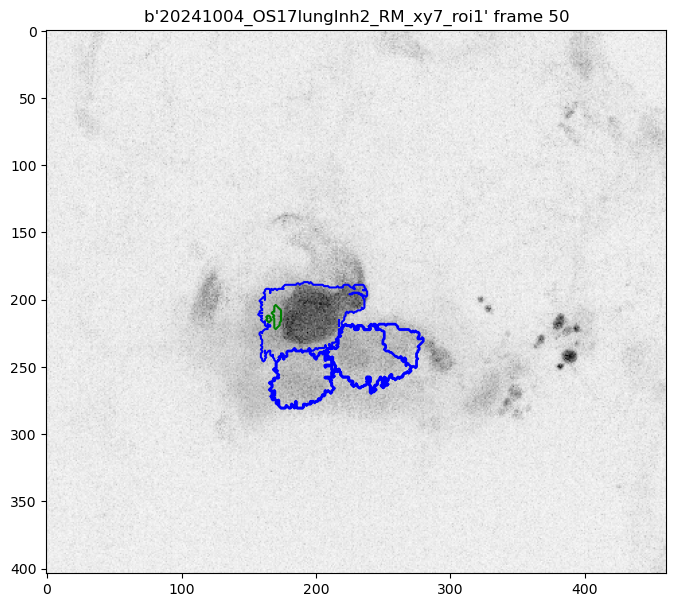

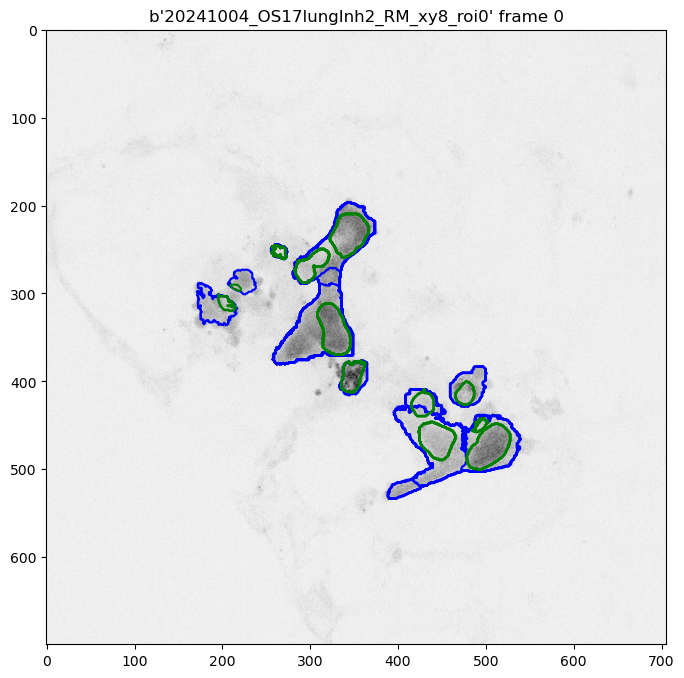

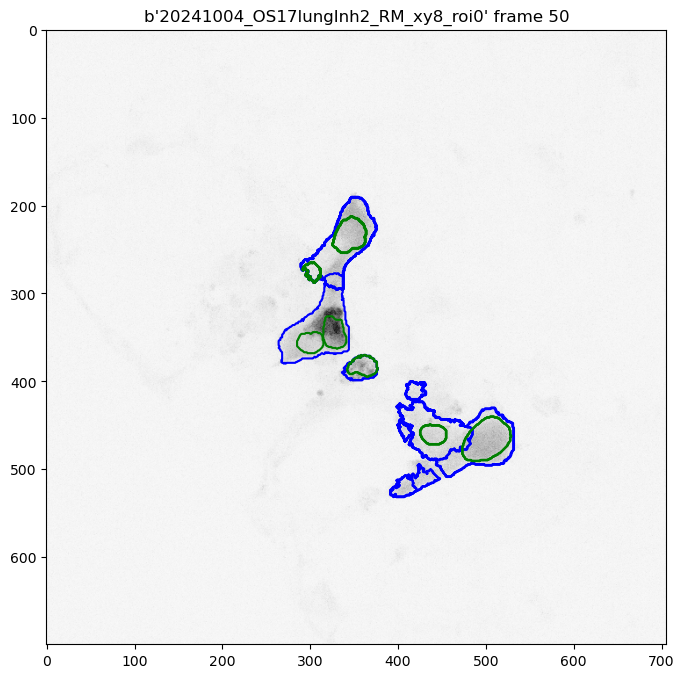

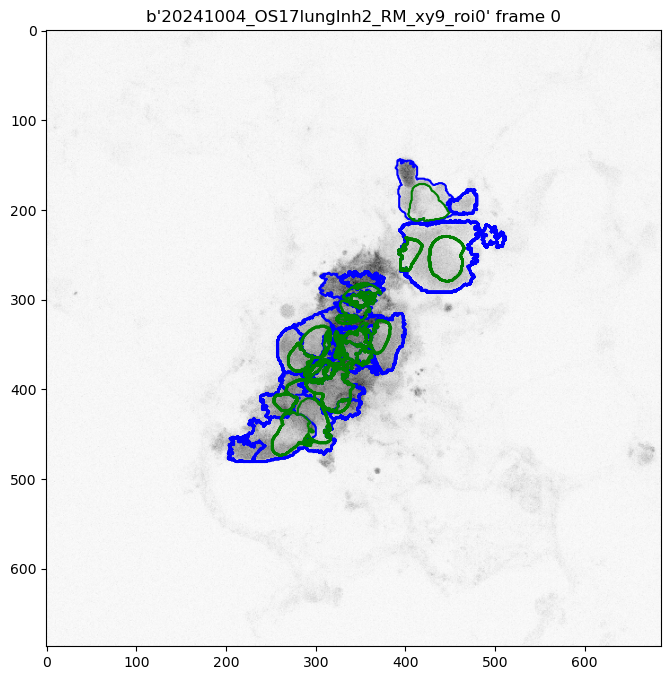

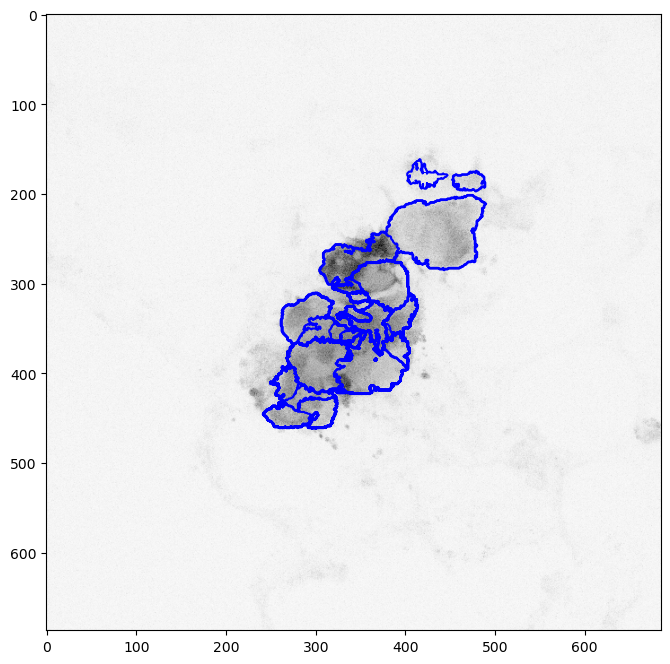

In [9]:
# take a look at segmentation
modelList_flat=list(itertools.chain(*modelLists))
modelSet=[None]*len(modelList_flat)
for i in range(len(modelList_flat)): 
    try:
        h5filename=modelList_flat[i]
        #moviename=modelNames[inds_imagingSet[i]] #messup no unique names
        modelSet[i]=trajectory.Trajectory(h5filename=h5filename)
        sctm=modelSet[i]
        moviename=sctm.figid #unique for each h5 file
        status=modelSet[i].load_from_h5('/cell_data_m0/')
        modelSet[i].get_image_shape()                             #some missing info, add in to metadata in future
        nuc_msk_channel=np.where(sctm.mask_channels==np.array(['nuc']).astype('S32'))[0][0]
        cyto_msk_channel=np.where(sctm.mask_channels==np.array(['cyto']).astype('S32'))[0][0]
        nuc_img_channel=np.where(sctm.channels==np.array(['DAPI']).astype('S32'))[0][0]
        rep_img_channel=np.where(sctm.channels==np.array(['YFP']).astype('S32'))[0][0]
        bf_img_channel=np.where(sctm.channels==np.array(['BF']).astype('S32'))[0][0]
        erk_img_channel=np.where(sctm.channels==np.array(['YFP']).astype('S32'))[0][0]
        akt_img_channel=np.where(sctm.channels==np.array(['TRITC']).astype('S32'))[0][0]
        fra1_img_channel=np.where(sctm.channels==np.array(['CFP']).astype('S32'))[0][0]
        mskchannel=sctm.mskchannel
        fmskchannel=sctm.fmskchannel
        nt_roi=sctm.nt;nx_roi=sctm.nx;ny_roi=sctm.ny;nz_roi=sctm.nz
        #sctm.cellpose_modelpath_nuc=cellpose_modelpath_nuc
        #sctm.cellpose_modelpath=cellpose_modelpath
        #sctm.save_to_h5('/metadata',['cellpose_modelpath_nuc','cellpose_modelpath'],overwrite=True)
        for iS in range(0,nt_roi,50):
            img=sctm.get_image_data(iS)
            msk=sctm.get_mask_data(iS)
            img_rep=np.max(img[...,erk_img_channel],axis=0)
            msk_nuc=np.max(msk[...,nuc_msk_channel],axis=0)
            msk_cyto=np.max(msk[...,cyto_msk_channel],axis=0)
            fig=plt.figure(figsize=(8,8))
            plt.imshow(img_rep,cmap=plt.cm.binary)
            plt.contour(msk_cyto,levels=np.unique(msk_cyto),colors='blue')
            plt.contour(msk_nuc,levels=np.unique(msk_nuc),colors='green')
            plt.title(f'{moviename} frame {iS}')
            plt.savefig(f'{vizpath}/segcheck_{moviename}_f{iS}.png')
    except Exception as e:
        print(e)

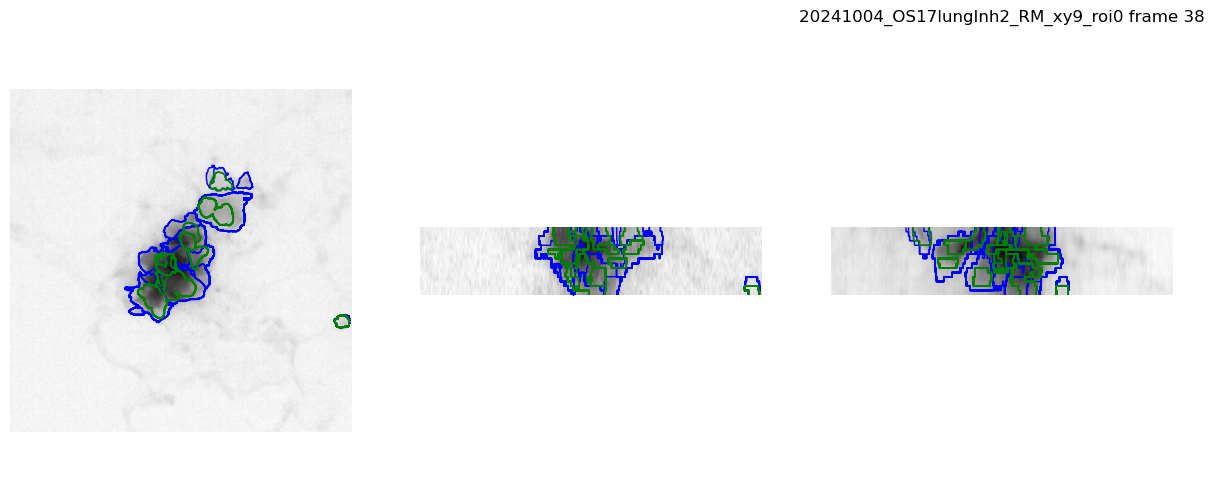

In [51]:
# Actual segmentation re-do
modelList_flat=list(itertools.chain(*modelLists))
modelSet=[None]*len(modelList_flat)
empty_array=[]
for i in range(len(modelList_flat)): 
    try:
        h5filename=modelList_flat[i]
        #with h5py.File(h5filename,'r+') as f: #comment out with the new segment and save script with binary masks
            #del f['/metadata/fmskchannel']    #comment out with the new segment and save script with binary masks
        #moviename=modelNames[inds_imagingSet[i]] #messup no unique names
        modelSet[i]=trajectory.Trajectory(h5filename=h5filename)
        sctm=modelSet[i]
        moviename=sctm.figid.decode() #unique for each h5 file
        #status=modelSet[i].load_from_h5('/cell_data_m0/')
        modelSet[i].get_image_shape()    #some missing info, add in to metadata in future
        #nuc_fmsk_channel=np.where(sctm.fmask_channels==np.array(['nuc']).astype('S32'))[0][0]
        #nuc_msk_channel=np.where(sctm.fmask_channels==np.array(['nuc']).astype('S32'))[0][0]
        cyto_msk_channel=np.where(sctm.mask_channels==np.array(['cyto']).astype('S32'))[0][0]
        nuc_img_channel=np.where(sctm.channels==np.array(['DAPI']).astype('S32'))[0][0]
        rep_img_channel=np.where(sctm.channels==np.array(['YFP']).astype('S32'))[0][0]
        bf_img_channel=np.where(sctm.channels==np.array(['BF']).astype('S32'))[0][0]
        erk_img_channel=np.where(sctm.channels==np.array(['YFP']).astype('S32'))[0][0]
        akt_img_channel=np.where(sctm.channels==np.array(['TRITC']).astype('S32'))[0][0]
        fra1_img_channel=np.where(sctm.channels==np.array(['CFP']).astype('S32'))[0][0]
        mskchannel=sctm.mskchannel
        #fmskchannel=sctm.fmskchannel
        nt_roi=sctm.nt;nx_roi=sctm.nx;ny_roi=sctm.ny;nz_roi=sctm.nz
        sctm.cellpose_modelpath_nuc=cellpose_modelpath_nuc
        sctm.cellpose_modelpath=cellpose_modelpath
        sctm.fmask_channels=fmask_channels
        sctm.mask_channels=mask_channels
        sctm.save_to_h5('/metadata/',['cellpose_modelpath_nuc','cellpose_modelpath','fmask_channels','mask_channels'],overwrite=True)
        print(f'loaded {sctm.h5filename} with {sctm.mask_channels} mask channels, {sctm.channels} image channels, cell index on {mskchannel}') 
        nuc_channel=nuc_img_channel
        rep_channel=erk_img_channel
        bf_channel=bf_img_channel
        print('d')
        for iS in range(nt_roi):
            vizfile=f'{vizpath}/zproj_{moviename}_f{iS:04d}.png'
            if not os.path.exists(vizfile):
                img=sctm.get_image_data(iS)
                #im3d_nuc=nuc_viewtransform(img[...,nuc_channel],rsmooth=nucl/16.,zscale=zscale,zcut_nuc=zcut_nuc)
                #im3d_rep=rep_viewtransform(img[...,rep_channel],rsmooth=1.0,zscale=zscale)
                #im3d_bf=bf_viewtransform(img[...,bf_channel],rsmooth=nucl/4.,zscale=zscale,zcut=zcut)
                im3d_nuc=rescale_to_int(imprep.znorm(img[...,nuc_channel]))
                if combine_nuc_channels:
                        nuc_dtype=im3d_nuc.dtype
                        im3d_nuc2=rescale_to_int(imprep.znorm(img[...,nuc_channel2]))
                im3d_nuc=.5*im3d_nuc2+.5*im3d_nuc
                im3d_nuc=im3d_nuc.astype(nuc_dtype)
                im3d_rep=rescale_to_int(imprep.znorm(img[...,rep_channel]))
                im3d_bf=imprep.znorm(img[...,bf_channel])
                im3d_bf=skimage.filters.difference_of_gaussians(im3d_bf,.5,1.5)
                im3d_bf=rescale_to_int(im3d_bf)
                cellpose_img=np.zeros((nz_roi,3,nx_roi,ny_roi)).astype(np.uint16)
                cellpose_img[:,0,:,:]=im3d_bf #add in nuc so not hollow
                cellpose_img[:,1,:,:]=im3d_rep
                cellpose_img[:,2,:,:]=im3d_nuc
                try:
                    masks, flows, styles = model.eval(cellpose_img, diameter=cellpose_diam, channels=cellpose_channels,do_3D=True,dP_smooth=2.0,anisotropy=zscale,min_size=minsize,cellprob_threshold=cellprob_threshold,flow_threshold=flow_threshold)
                    #masks, flows, styles = model.eval(cellpose_img, diameter=cellpose_diam, channels=cellpose_channels,do_3D=False,stitch_threshold=.1,anisotropy=zscale,min_size=minsize,cellprob_threshold=cellprob_threshold,flow_threshold=flow_threshold)
                    #masks, flows, styles = model.eval(cellpose_img, diameter=cellpose_diam, channels=cellpose_channels,do_3D=False,anisotropy=zscale,min_size=minsize,stitch_threshold=.1,cellprob_threshold=cellprob_threshold)
                except Exception as e:
                    print(f'cellpose failure for cyto {moviename} frame {iS} error {e}, substituting zero array')
                    masks=np.zeros_like(im3d_rep).astype(int)
                try:
                    masks_nuc, flows_nuc, styles_nuc = model_nuc.eval(cellpose_img, diameter=cellpose_diam_nuc, channels=cellpose_channels_nuc,do_3D=False,anisotropy=zscale,min_size=minsize,stitch_threshold=.1,cellprob_threshold=cellprob_threshold_nuc,flow_threshold=flow_threshold_nuc)
                except Exception as e:
                    print(f'cellpose failure for nuc {moviename} frame {iS} error {e}, substituting zero array')
                    masks_nuc=np.zeros_like(im3d_rep).astype(int)
                img_bf=img[:,:,:,bf_channel]
                img_bf_dog=skimage.filters.difference_of_gaussians(imprep.znorm(img_bf),.5,1.5)
                img_bf_smth=skimage.filters.gaussian(np.abs(img_bf_dog),sigma=[rsmooth/zscale,rsmooth,rsmooth])
                fmsk=imprep.znorm(img_bf_smth)>zcut
                img_nuc_smth=skimage.filters.gaussian(img[...,nuc_channel],sigma=[rsmooth_nuc/zscale,rsmooth_nuc,rsmooth_nuc])
                img_rep_smth=skimage.filters.gaussian(img[...,rep_channel],sigma=[rsmooth/zscale,rsmooth,rsmooth])
                #nucmsk=imprep.znorm(img[...,nuc_channel])>nuc_cut
                nucmsk=imprep.local_threshold(img_nuc_smth,block_size=imprep.make_odd(2*nucl),z_std=zcut_nuc)
                repmsk=imprep.local_threshold(img_rep_smth,block_size=imprep.make_odd(2*nucl),z_std=zcut_nuc)
                fmsk=np.logical_or(fmsk,repmsk);fmsk=np.logical_or(fmsk,nucmsk)
                fmsk=binary_fill_holes_2dstack(fmsk)
                labels_cyto=imprep.clean_labeled_mask(masks,minsize=minsize,maxsize=maxsize,fill_holes=True,selection='largest') #,test_map=nucmsk,test_cut=nucl,verbose=True)
                labels_nuc=labels_cyto.copy()
                labels_nuc[np.logical_not(masks_nuc>0)]=0
                fmsk_nuc=labels_nuc>0
                #labels_nuc[np.logical_not(fmsk)]=0
                #labels_cyto_only=imprep.get_cyto_minus_nuc_labels(labels_cyto,labels_nuc)
                label=np.zeros((nz_roi,nx_roi,ny_roi,1)).astype(np.int16)
                label[:,:,:,0]=labels_cyto
                fmsks=np.zeros((nz_roi,nx_roi,ny_roi,2)).astype(bool)
                fmsks[:,:,:,0]=fmsk
                fmsks[:,:,:,1]=fmsk_nuc
                imprep.save_frame_h5(sctm.h5filename,iS,img=img,msks=label,fmsk=fmsks,overwrite=True,timestamp=None)
                if np.sum(labels_cyto)==0:
                    empty_array.append(f'{h5filename} frame {iS}')
                    print(f'no cells segmented {h5filename} frame {iS}')
                if visual and np.sum(labels_cyto>0):
                    clear_output(wait=True);
                    try:
                        fig=plt.figure(figsize=(15,6))
                        plt.clf()
                        #img_bf_dog=np.abs(imprep.znorm(img_bf_dog))
                        #img_bf_dog[np.logical_not(fmsk)]=0
                        if np.sum(labels_nuc>0):
                            show_3dseg_zproj(fig,rep_viewtransform(im3d_rep,zscale=zscale),labels_cyto,labels2=labels_nuc,fmsk=None,zscale=sctm.zscale) #,fmap=im3d_reporter_ratio,fmapscale=(0,3))
                        else:
                            show_3dseg_zproj(fig,rep_viewtransform(im3d_rep,zscale=zscale),labels_cyto,labels2=None,fmsk=None,zscale=sctm.zscale)
                        plt.title(f'{moviename} frame {iS}');
                        plt.savefig(vizfile)
                        if live_render:
                            plt.pause(.1)
                    except Exception as e:
                        print(e)
                #label[:,:,:,1]=labels_nuc
                #label[:,:,:,2]=fmsk
                #img=np.zeros((nz_roi,nx_roi,ny_roi,3))
                #img[:,:,:,0]=imgs_roi[iS,...,bf_channel]
                #img[:,:,:,1]=imgs_roi[iS,...,nuc_channel]
                #img[:,:,:,2]=imgs_roi[iS,...,rep_channel]
    except Exception as e:
        print(e)
        pass